In [1]:
import torch
from bertviz import head_view
from transformers import MT5TokenizerFast, MT5ForConditionalGeneration
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

from overfit_attention import prepare_text_input


In [2]:
# Some features are shared among all models
shortest_article_ids = [260, 1301, 2088, 665, 1572, 436, 1887, 1422, 1506, 474]

dataset = load_dataset("dennlinger/klexikon")
tokenizer = MT5TokenizerFast.from_pretrained("google/mt5-small")

for idx in shortest_article_ids:
    # Load index-specific model
    model = MT5ForConditionalGeneration.from_pretrained(f"./overfit_models/{idx}")
    
    sample = dataset["train"][idx]
    # Prepare with sensible border tokens. Decoder needs to start with <pad>
    wiki_text = f"<extra_id_0> {prepare_text_input(sample['wiki_sentences'], max_sentences=15)}"
    klexikon_text = f"<pad> {prepare_text_input(sample['klexikon_sentences'], max_sentences=5)}"

    # Prepare forward pass
    model_inputs = tokenizer(wiki_text, return_tensors="pt")
    decoder_inputs = tokenizer(klexikon_text, return_tensors="pt")
    model_inputs["decoder_input_ids"] = decoder_inputs["input_ids"]
    
    result = model(input_ids=model_inputs["input_ids"], attention_mask=model_inputs["attention_mask"],
                   decoder_input_ids=model_inputs["decoder_input_ids"], output_attentions=True,
                   labels=model_inputs["decoder_input_ids"])
    
    # Check predicted tokens for sanity check
    predicted_ids = torch.argmax(result.logits.detach().to("cpu"), dim=-1)
    print(tokenizer.decode(predicted_ids[0]))
    
    break


Using custom data configuration dennlinger--klexikon-713c6b3fddad5d3f
Reusing dataset json (/home/dennis/.cache/huggingface/datasets/json/dennlinger--klexikon-713c6b3fddad5d3f/0.0.0/c90812beea906fcffe0d5e3bb9eba909a80a998b5f88e9f8acbd320aa91acfde)


  0%|          | 0/3 [00:00<?, ?it/s]

<pad></s>Eine Blume ist der farbige Teil einer Pflanze. <extra_id_1> Eine Blume ist eigentlich eine Blüte. <extra_id_1> In der Blüte bilden sich die Samen. <extra_id_1> Die meisten Blumen brauchen Insekten, welche die Bestäubung übernehmen. <extra_id_1> So können sich dann Samen bilden.</s>


In [3]:
len(result.cross_attentions)

8

In [5]:
result.cross_attentions[0][0,0,:,:].detach().numpy()

array([[1.1443987e-04, 2.3527838e-04, 2.3657412e-04, ..., 5.9100566e-05,
        5.1255829e-05, 6.0391012e-05],
       [2.4331753e-04, 1.4051136e-04, 1.5140099e-04, ..., 3.8010138e-03,
        1.9763072e-03, 1.4918630e-02],
       [1.0647230e-04, 1.8465974e-04, 1.5210202e-04, ..., 9.2040369e-04,
        1.6043212e-03, 4.9049687e-02],
       ...,
       [8.9709691e-05, 2.1584901e-04, 4.6336652e-05, ..., 2.5362111e-04,
        2.6652700e-04, 3.5407001e-01],
       [1.5538792e-03, 1.9496080e-03, 2.0468752e-03, ..., 7.8630442e-04,
        6.1825272e-03, 2.2834098e-02],
       [8.2452796e-05, 1.1002689e-04, 7.0812384e-05, ..., 2.7075403e-06,
        4.0671981e-05, 2.9440781e-03]], dtype=float32)

In [11]:
first_layer = result.cross_attentions[0]

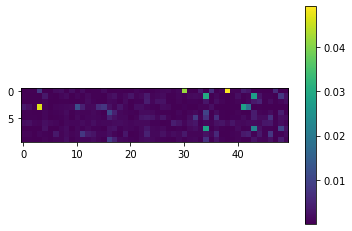

In [13]:
# Verify plotting works
plt.imshow(first_layer[0,0,:10,:50].detach().numpy(), interpolation="none")
plt.colorbar()
plt.show()

In [7]:
max(result.cross_attentions[0][0,0,0,:])

tensor(0.0626, grad_fn=<UnbindBackward0>)

In [16]:
subwords_input = tokenizer.convert_ids_to_tokens(model_inputs["input_ids"][0])
print(subwords_input)

['▁<extra_id_0>', '▁', 'Eine', '▁Blum', 'e', '▁(', 'von', '▁alt', 'hoch', 'deutsch', '▁blu', 'oma', ',', '▁von', '▁indo', 'german', 'isch', '▁b', 'hlo', ',', '▁"', 'bl', 'ühen', ',', '▁zum', '▁Vor', 'schein', '▁kommen', '")', '▁be', 'zeichnet', '▁in', '▁der', '▁Alltag', 's', 'sprache', '▁', 'ent', 'weder', '▁eine', '▁B', 'lüten', 'pflanz', 'e', ',', '▁die', '▁', 'größe', 're', ',', '▁in', 's', '▁Auge', '▁fa', 'llende', '▁B', 'lüten', '▁"', 'her', 'vor', 'bring', 't', '",', '▁oder', '▁eine', '▁"', 'einzel', 'ne', '▁B', 'lüt', 'e', '▁', 'einer', '▁Blum', 'e', '▁mit', '▁S', 'tiel', '"', '▁oder', '▁wird', '▁als', '▁Kurz', 'form', '▁für', '▁Blumen', 'stock', '▁', 'verwend', 'et', '.', '▁<extra_id_1>', '▁Sie', '▁', 'dient', '▁of', 't', '▁als', '▁Schmuck', ',', '▁z', '.', '▁B', '.', '▁als', '▁Schnitt', 'blu', 'me', '▁in', '▁', 'einem', '▁Blumen', 'stra', 'uß', ',', '▁als', '▁Blumen', 'kran', 'z', '▁oder', '▁Blumen', 'ge', 'binde', '.', '▁<extra_id_1>', '▁In', '▁der', '▁Bild', 'enden', '▁Kunst

In [18]:
subwords_output = tokenizer.convert_ids_to_tokens(decoder_inputs["input_ids"][0])
print(subwords_output)

['<pad>', '▁', 'Eine', '▁Blum', 'e', '▁ist', '▁der', '▁', 'farbig', 'e', '▁Teil', '▁', 'einer', '▁Pflanze', '.', '▁<extra_id_1>', '▁', 'Eine', '▁Blum', 'e', '▁ist', '▁eigen', 'tlich', '▁eine', '▁B', 'lüt', 'e', '.', '▁<extra_id_1>', '▁In', '▁der', '▁B', 'lüt', 'e', '▁', 'bilden', '▁sich', '▁die', '▁', 'Samen', '.', '▁<extra_id_1>', '▁Die', '▁meist', 'en', '▁Blumen', '▁', 'brauche', 'n', '▁In', 's', 'ekten', ',', '▁wel', 'che', '▁die', '▁B', 'estä', 'ubung', '▁über', 'nehmen', '.', '▁<extra_id_1>', '▁So', '▁können', '▁sich', '▁dann', '▁', 'Samen', '▁', 'bilden', '.', '</s>']


In [25]:
input_indices = [0] + [idx for idx, subword in enumerate(subwords_input) if "<extra_id_1>" in subword] + [len(subwords_input)]
print(input_indices)

[0, 91, 124, 146, 178, 244, 264, 291, 307, 339, 367, 388, 404, 432, 448, 468]


In [26]:
output_indices = [0] + [idx for idx, subword in enumerate(subwords_output) if "<extra_id_" in subword] + [len(subwords_output)]
print(output_indices)

[0, 15, 28, 41, 62, 73]


In [45]:
def aggregate_matrix_into_sentence_based(attn_matrix, in_indices, out_indices):
    res = np.zeros([len(in_indices) - 1, len(out_indices) - 1])
    
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i, j] = np.sum(attn_matrix[0, 0, out_indices[j]:out_indices[j+1], in_indices[i]:in_indices[i+1]])
    
    return res

In [48]:
sentence_attentions = aggregate_matrix_into_sentence_based(first_layer, input_indices, output_indices)
print(sentence_attentions)

[[2.99834347 1.96102762 1.83671045 2.63361096 1.74681377]
 [1.32212567 1.06229305 0.90848804 1.30420494 0.71076196]
 [0.5669136  0.56196082 0.55123651 0.86826968 0.57211471]
 [1.12888217 0.70184654 0.60533977 0.82460773 0.5191927 ]
 [1.94138622 1.4283762  1.37748134 2.05443859 1.26449585]
 [0.51642746 0.36479363 0.34927329 0.48452353 0.38499814]
 [0.50165701 0.48785535 0.55719256 0.92564678 0.554685  ]
 [0.37796679 0.23677078 0.2238479  0.33245325 0.19093746]
 [1.08089793 0.84333092 0.80556703 1.30009651 0.74932778]
 [0.70107329 0.67429125 0.68420053 1.09742188 0.59883356]
 [0.61834311 0.48454788 0.51920652 0.64104021 0.4593949 ]
 [0.49124253 0.50950217 0.51333714 0.74177253 0.459095  ]
 [0.78559119 0.78968942 0.75422776 1.11400676 0.69932175]
 [0.601026   0.54315913 0.50232059 0.65694654 0.43151054]
 [1.36812329 2.35055518 2.81157064 6.02095985 1.65851665]]


In [34]:
first_layer = first_layer.detach().numpy()

In [42]:
first_layer.shape

(1, 6, 73, 468)

In [50]:
sentence_attentions[:, 0].sum()

14.999999731779099

In [62]:
normalized_sentence_attentions = sentence_attentions / np.sum(sentence_attentions, axis=0)[None, :]
print(normalized_sentence_attentions)

[[0.19988957 0.15084828 0.14128542 0.12541005 0.15880126]
 [0.08814171 0.08171485 0.06988369 0.062105   0.06461473]
 [0.03779424 0.04322776 0.04240281 0.04134618 0.05201043]
 [0.07525881 0.0539882  0.0465646  0.03926704 0.04719934]
 [0.12942575 0.10987509 0.1059601  0.09783041 0.11495417]
 [0.0344285  0.02806105 0.02686718 0.02307255 0.03499983]
 [0.0334438  0.03752733 0.04286097 0.04407842 0.05042591]
 [0.02519779 0.01821314 0.01721907 0.01583111 0.01735795]
 [0.07205986 0.06487161 0.06196669 0.06190936 0.06812071]
 [0.04673822 0.05186856 0.05263081 0.05225819 0.05443942]
 [0.04122288 0.03727291 0.03993896 0.03052572 0.04176317]
 [0.0327495  0.03919247 0.03948747 0.0353225  0.04173591]
 [0.05237275 0.06074534 0.05801752 0.05304794 0.06357471]
 [0.0400684  0.04178147 0.03864005 0.03128317 0.03922823]
 [0.09120822 0.18081194 0.21627466 0.28671238 0.15077424]]


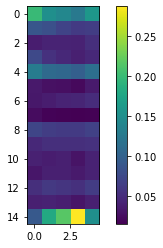

In [63]:
plt.imshow(normalized_sentence_attentions, interpolation="none")
plt.colorbar()
plt.show()